This notebook applies hierarchical bayesian modeling using three variables: precipitation and distance to water bodies, and soil characteristics

In [14]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import theano.tensor as tt
import scipy.stats as stats 
import seaborn as sns

import geopandas as gpd
import censusdata
from scripts import *
tqdm.pandas()

%matplotlib inline

# Data Pre-Processing

In [2]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v2.csv',
                                          cols=['sewageSystem', 'ppt_2013', 'water_dist', 'gSSURGO_GA'],
                                          is_balanced=True)

balancing...
repairs: 11.054594777890811%, non-repairs: 88.94540522210919%


In [3]:
# soil information (in in/h), normalized
soil_dict = {
    'A': 6.00,
    'B': 3.50,
    'C': 0.78,
    'D': 0.14
}

df['hydraulic_c'] = df['gSSURGO_GA'].str[0] # get the first value if a system has more than one soil type
df['hydraulic_c'] = df['hydraulic_c'].replace(soil_dict)
df['hydraulic_c_norm'] = (df['hydraulic_c'] - df['hydraulic_c'].min()) / (df['hydraulic_c'].max() - df['hydraulic_c'].min())

## Housing Data

In [4]:
# Table lookup
censusdata.printtable(censusdata.censustable('acs5', 2019, 'B25077'))

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B25077_001E  | MEDIAN VALUE (DOLLARS)         | !! Estimate Median value (dollars)                       | int  
-------------------------------------------------------------------------------------------------------------------


In [5]:
# Download and rename columns
ga_acs = (censusdata.download('acs5', 
                             2019,
                             censusdata.censusgeo([('state', '13'), ('county', '*')]),
                             ['B25077_001E'])
          .reset_index()
          .rename(columns={'B25077_001E': 'median_hse'}))

In [6]:
def match_acs_features(septic_df, acs_df, pri_key, for_key, var_name):
    # extract county name with columns: ['index', 'County']
    for i, row in acs_df.iterrows():
        county = (str(row['index'])
                  .split(',')[0]
                  .split(for_key)[0]
                  .strip()
                  .upper())

        acs_df.loc[i, for_key] = county
        
    # match with our septic systems with columns ['tblSGA_Property.county_property']
    for i, row in septic_df.iterrows():
        septic_cty = str(row[pri_key])
        match_idx = acs_df.index[acs_df[for_key]==septic_cty][0]
        median_hse = acs_df[var_name][match_idx]
        septic_df.loc[i,var_name] = median_hse
        
    return septic_df

In [7]:
# get median housing value
df = match_acs_features(
        df, 
        ga_acs, 
        pri_key='tblSGA_Property.county_property',
        for_key='County',
        var_name='median_hse'
    )

df = normalize(df, var='median_hse', var_norm='median_hse_norm')

# Hierarchical Bayesian Model

- Group septic systems based on their basin (~1560 basins)
- The effect of precipitation, distance to water bodies, and soil characteristic to septic's status

## Empirical Distributions
Empirical analysis for 

1. distance to water bodies, precipitation: `01 hierarchical_bayesian_twovars`
2. distance to soil hydraulic conductivity: `02 hierarchical_bayesian_threevars`

### a) Median Housing

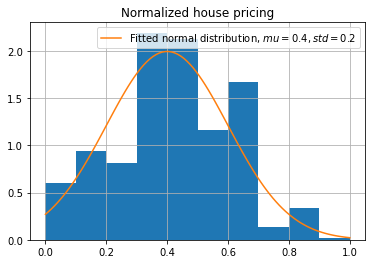

In [8]:
# plotting distribution (using Normal distribution)
x = np.linspace(0,1,100)
y = stats.norm.pdf(x, loc=0.4, scale=0.2)
df['median_hse_norm'].hist(density=True)
plt.plot(x,y, label="Fitted normal distribution, $mu=0.4, std=0.2$")
plt.title("Normalized house pricing")
plt.legend()

## Water Distance, Precipitation, and Hydraulics on Sewage Status $Y$

The new variable, median housing price ($v$):

$$
\begin{align}
    \textbf{Housing parameters}\\
    \beta_{h,k} \sim HN_{v,k}(\sigma=\sigma_v)\\
    \sigma_v \sim HN_v(\sigma=10)\\
\end{align}
$$

The full hierarchical bayesian formula is as follows:
$$
\begin{align}
    Y_{k} \sim Bernoulli(\theta_{k})\\
    \theta_{k} = \sigma(\beta_{0,k} + \beta_{w,k} * waterdist + \beta_{p,k} * precip + \beta_{h_k})\\
    \textbf{Intercept parameters}\\
    \beta_{0,k} \sim N_{0,k}(\mu=\mu_{0}, \sigma=\theta_{0})\\
    \mu_{0} \sim HN_0(\sigma=10), \quad \theta_{0} \sim HN_0(\sigma=10)\\
    \textbf{Water distance parameters}\\
    \beta_{w,k} \sim \Gamma_{w,k}(\alpha=\alpha_w, \beta=\beta_w)\\
    \alpha_w \sim HN_w(\sigma=1), \quad \beta_w \sim HN_w(\sigma=5)\\
    \textbf{Precipitation parameters}\\
    \beta_{p,k} \sim HN_{p,k}(\sigma=\sigma_p)\\
    \sigma_p \sim HN_p(\sigma=10)\\
    \textbf{Hydraulics parameters}\\
    \beta_{h,k} \sim U_{h,k}(lower=0,upper=\sigma_h)\\
    \sigma_h \sim HN_h(\sigma=10)\\
    \textbf{Housing parameters}\\
    \beta_{h,k} \sim HN_{v,k}(\sigma=\sigma_v)\\
    \sigma_v \sim HN_v(\sigma=10)\\
    \text{the subscript $w$, $p$, $h$, and $v$ denote distance to water bodies, precipitation, hydraulics respectively, and housing value at the $k$-th basin}\\
    \text{$\sigma$ (inverse logistic) function returns the binary value of 0 (repair) or 1 (new/addition)}
\end{align}
$$

In [9]:
# Modeling
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')

    # global model parameters
    wtr_alpha = pm.HalfNormal('wtr_alpha', sigma=1.)
    wtr_beta = pm.HalfNormal('wtr_beta', sigma=5)
    ppt_mu = pm.HalfNormal('ppt_mu', sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=5)
    mu_c = pm.HalfNormal('mu_c', sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    wtr_dist = pm.Gamma('wtr_dist', alpha=wtr_alpha, beta=wtr_beta, dims='basin')
    ppt = pm.HalfNormal('ppt', sigma=ppt_sig, dims='basin')
    hydr = pm.Uniform('hydr', lower=0, upper=hydr_sig, dims='basin')
    hse = pm.HalfNormal('hse', sigma=hse_sig, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin_idx] 
                                    + wtr_dist[basin_idx] * water_d 
                                    + ppt[basin_idx] * ppt_d
                                    + hydr[basin_idx] * hydr_d
                                    + hse[basin_idx] * hse_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=200, cores=4, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, hse, hydr, ppt, wtr_dist, sigma_c, mu_c, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'wtr_dist'}>,
        <AxesSubplot:title={'center':'wtr_dist'}>],
       [<AxesSubplot:title={'center':'ppt'}>,
        <AxesSubplot:title={'center':'ppt'}>],
       [<AxesSubplot:title={'center':'hydr'}>,
        <AxesSubplot:title={'center':'hydr'}>],
       [<AxesSubplot:title={'center':'hse'}>,
        <AxesSubplot:title={'center':'hse'}>]], dtype=object)

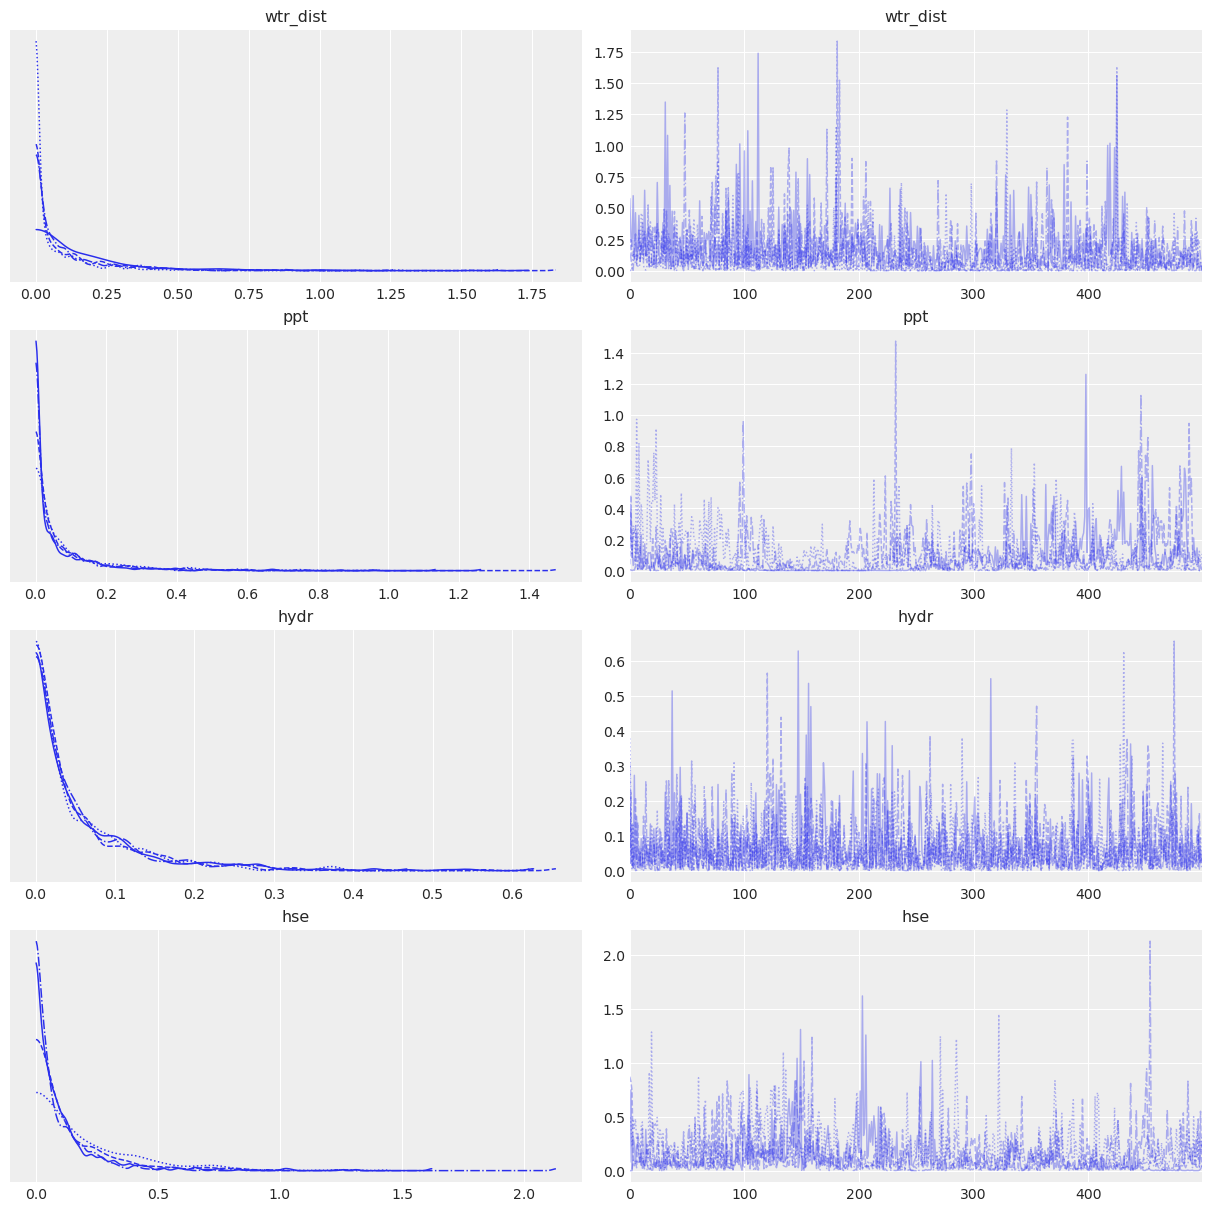

In [95]:
# get sample basin for analysis
sample_coords = {'basin': df.HU_12_NAME[:1].values}
var_names=['wtr_dist', 'ppt', 'hydr', 'hse']

# analyze the posterior distribution (fitted parameters)
az.plot_trace(trace, var_names=var_names, coords=sample_coords, figsize=(12,12), compact=True)

In [47]:
# evaluate model
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.33742331288343%


# Evaluation

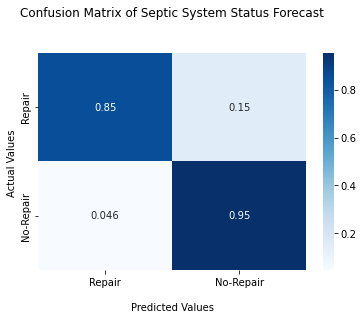

In [31]:
# Confusion matrix
cf = confusion_matrix(y, y_pred, labels=None, sample_weight=None, normalize='true')
ax = sns.heatmap(cf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix of Septic System Status Forecast\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Repair','No-Repair'])
ax.yaxis.set_ticklabels(['Repair','No-Repair'])
plt.show()

array([[<AxesSubplot:title={'center':'wtr_dist\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'ppt\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'hydr\nWest Chickamauga Creek'}>],
       [<AxesSubplot:title={'center':'hse\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'c\nWest Chickamauga Creek'}>,
        <AxesSubplot:>]], dtype=object)

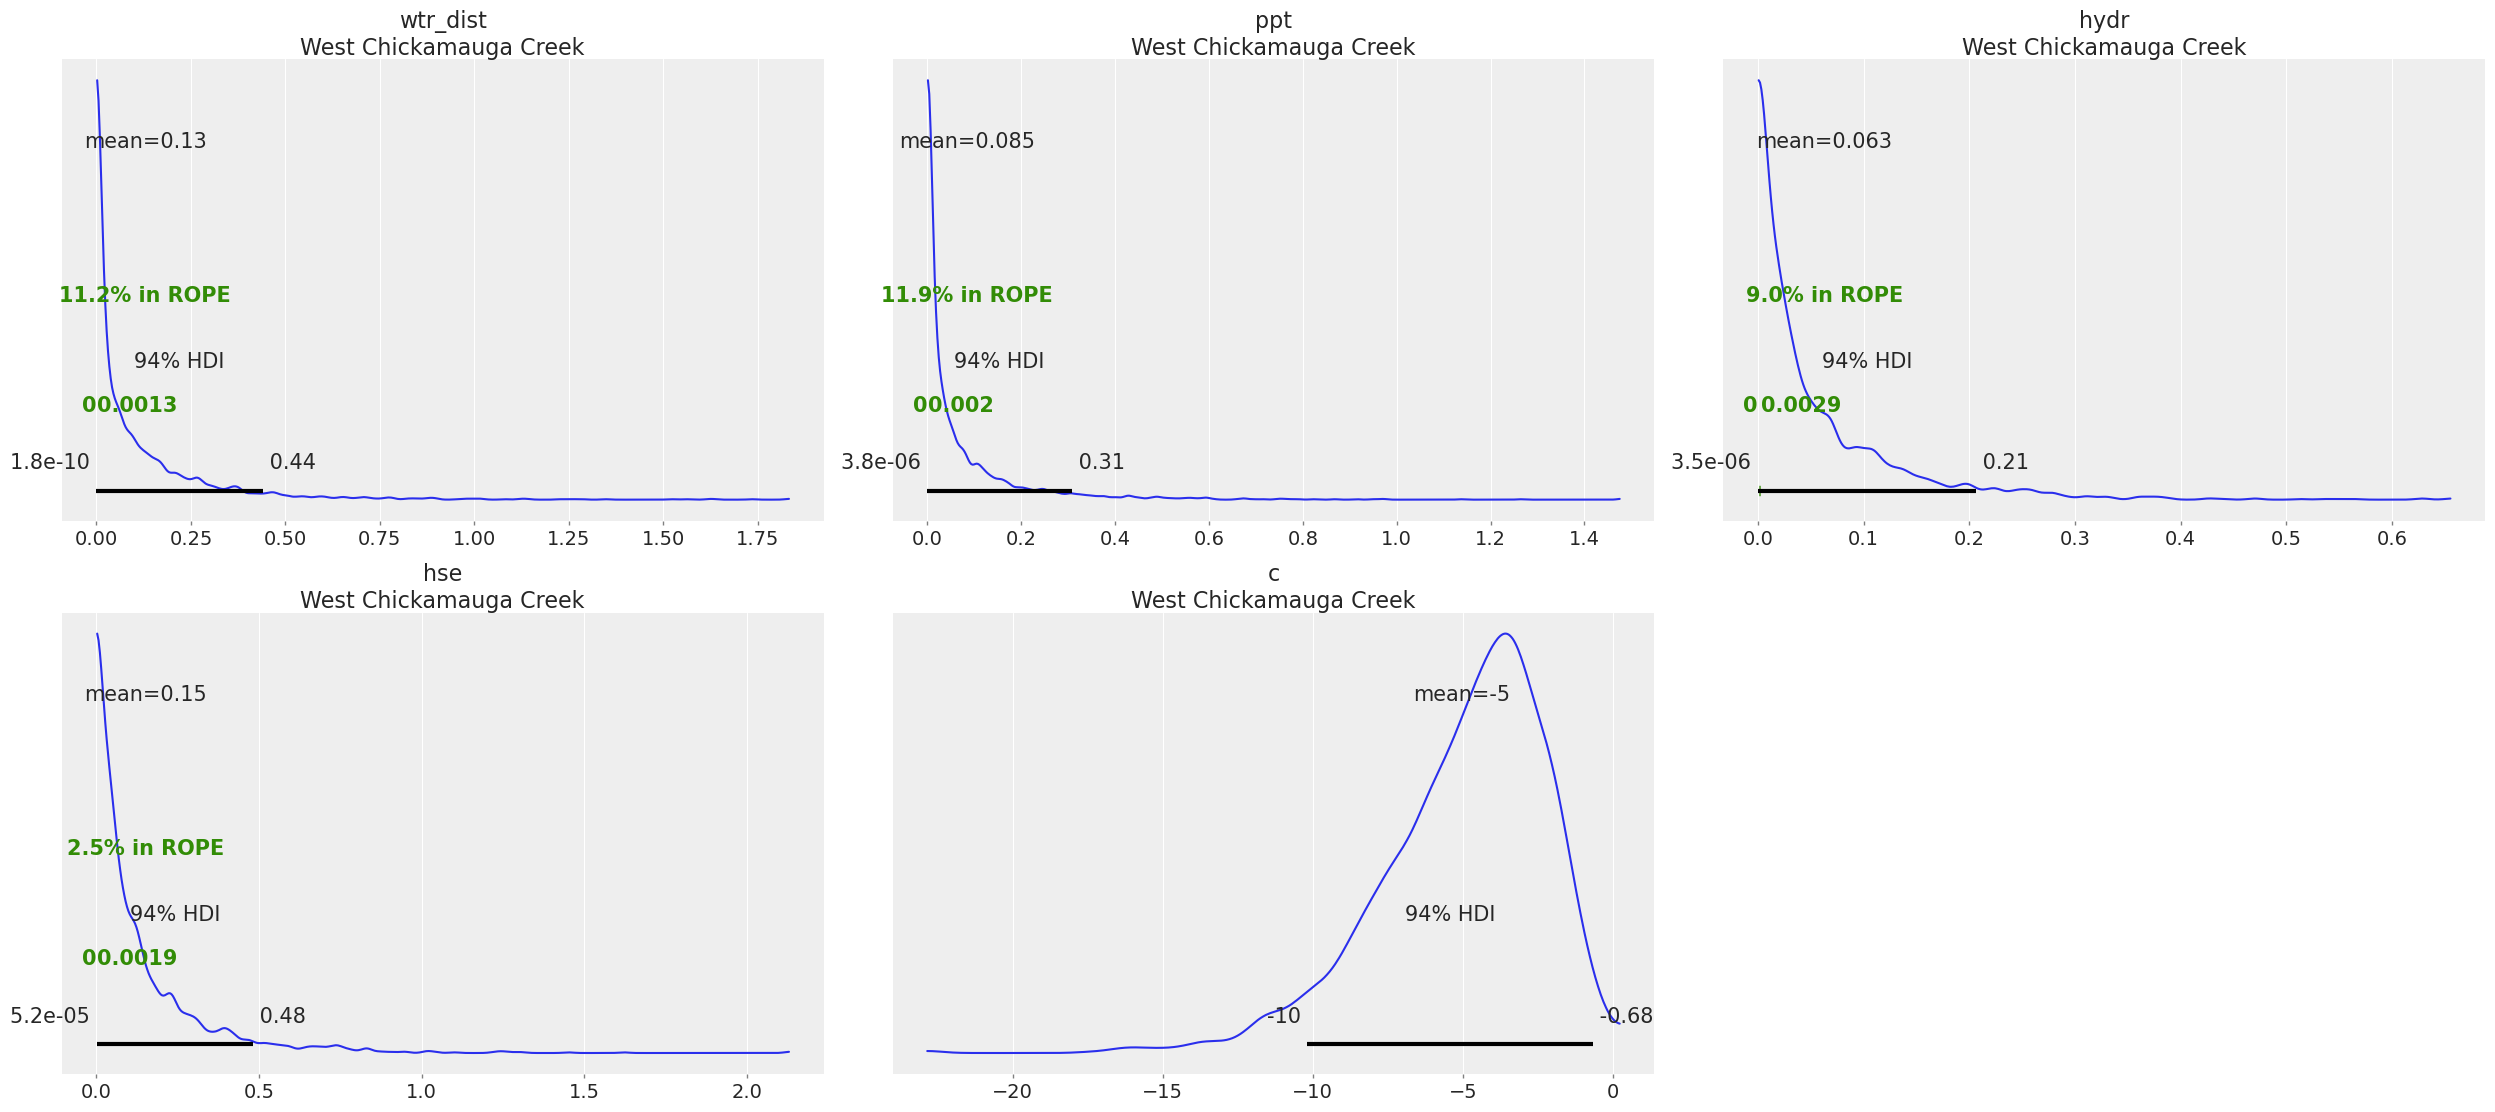

In [69]:
"""
posterior distribution with high density interval (HDI) and region of practical equivalence (ROPE)
analog of ROPE in frequentist statistics: null hypothesis (instead of point, in Bayesian we define a region)
region interval: [0, 0.01 * std] for normalized values according to Kruschke (2018)

"""
rope = {'wtr_dist': [{'rope': (0, df.water_dist_norm.values.std() * 0.01)}], 
        'ppt': [{'rope': (0, df.ppt_2013_norm.values.std() * 0.01)}],
        'hydr': [{'rope': (0, df.hydraulic_c_norm.values.std() * 0.01)}],
        'hse': [{'rope': (0, df.median_hse_norm.values.std() * 0.01)}]
       }
az.plot_posterior(trace, coords=sample_coords, var_names=var_names, rope=rope)

array([[<AxesSubplot:ylabel='ppt\nWest Chickamauga Creek'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='hydr\nWest Chickamauga Creek'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='wtr_dist\nWest Chickamauga Creek', ylabel='hse\nWest Chickamauga Creek'>,
        <AxesSubplot:xlabel='ppt\nWest Chickamauga Creek'>,
        <AxesSubplot:xlabel='hydr\nWest Chickamauga Creek'>]],
      dtype=object)

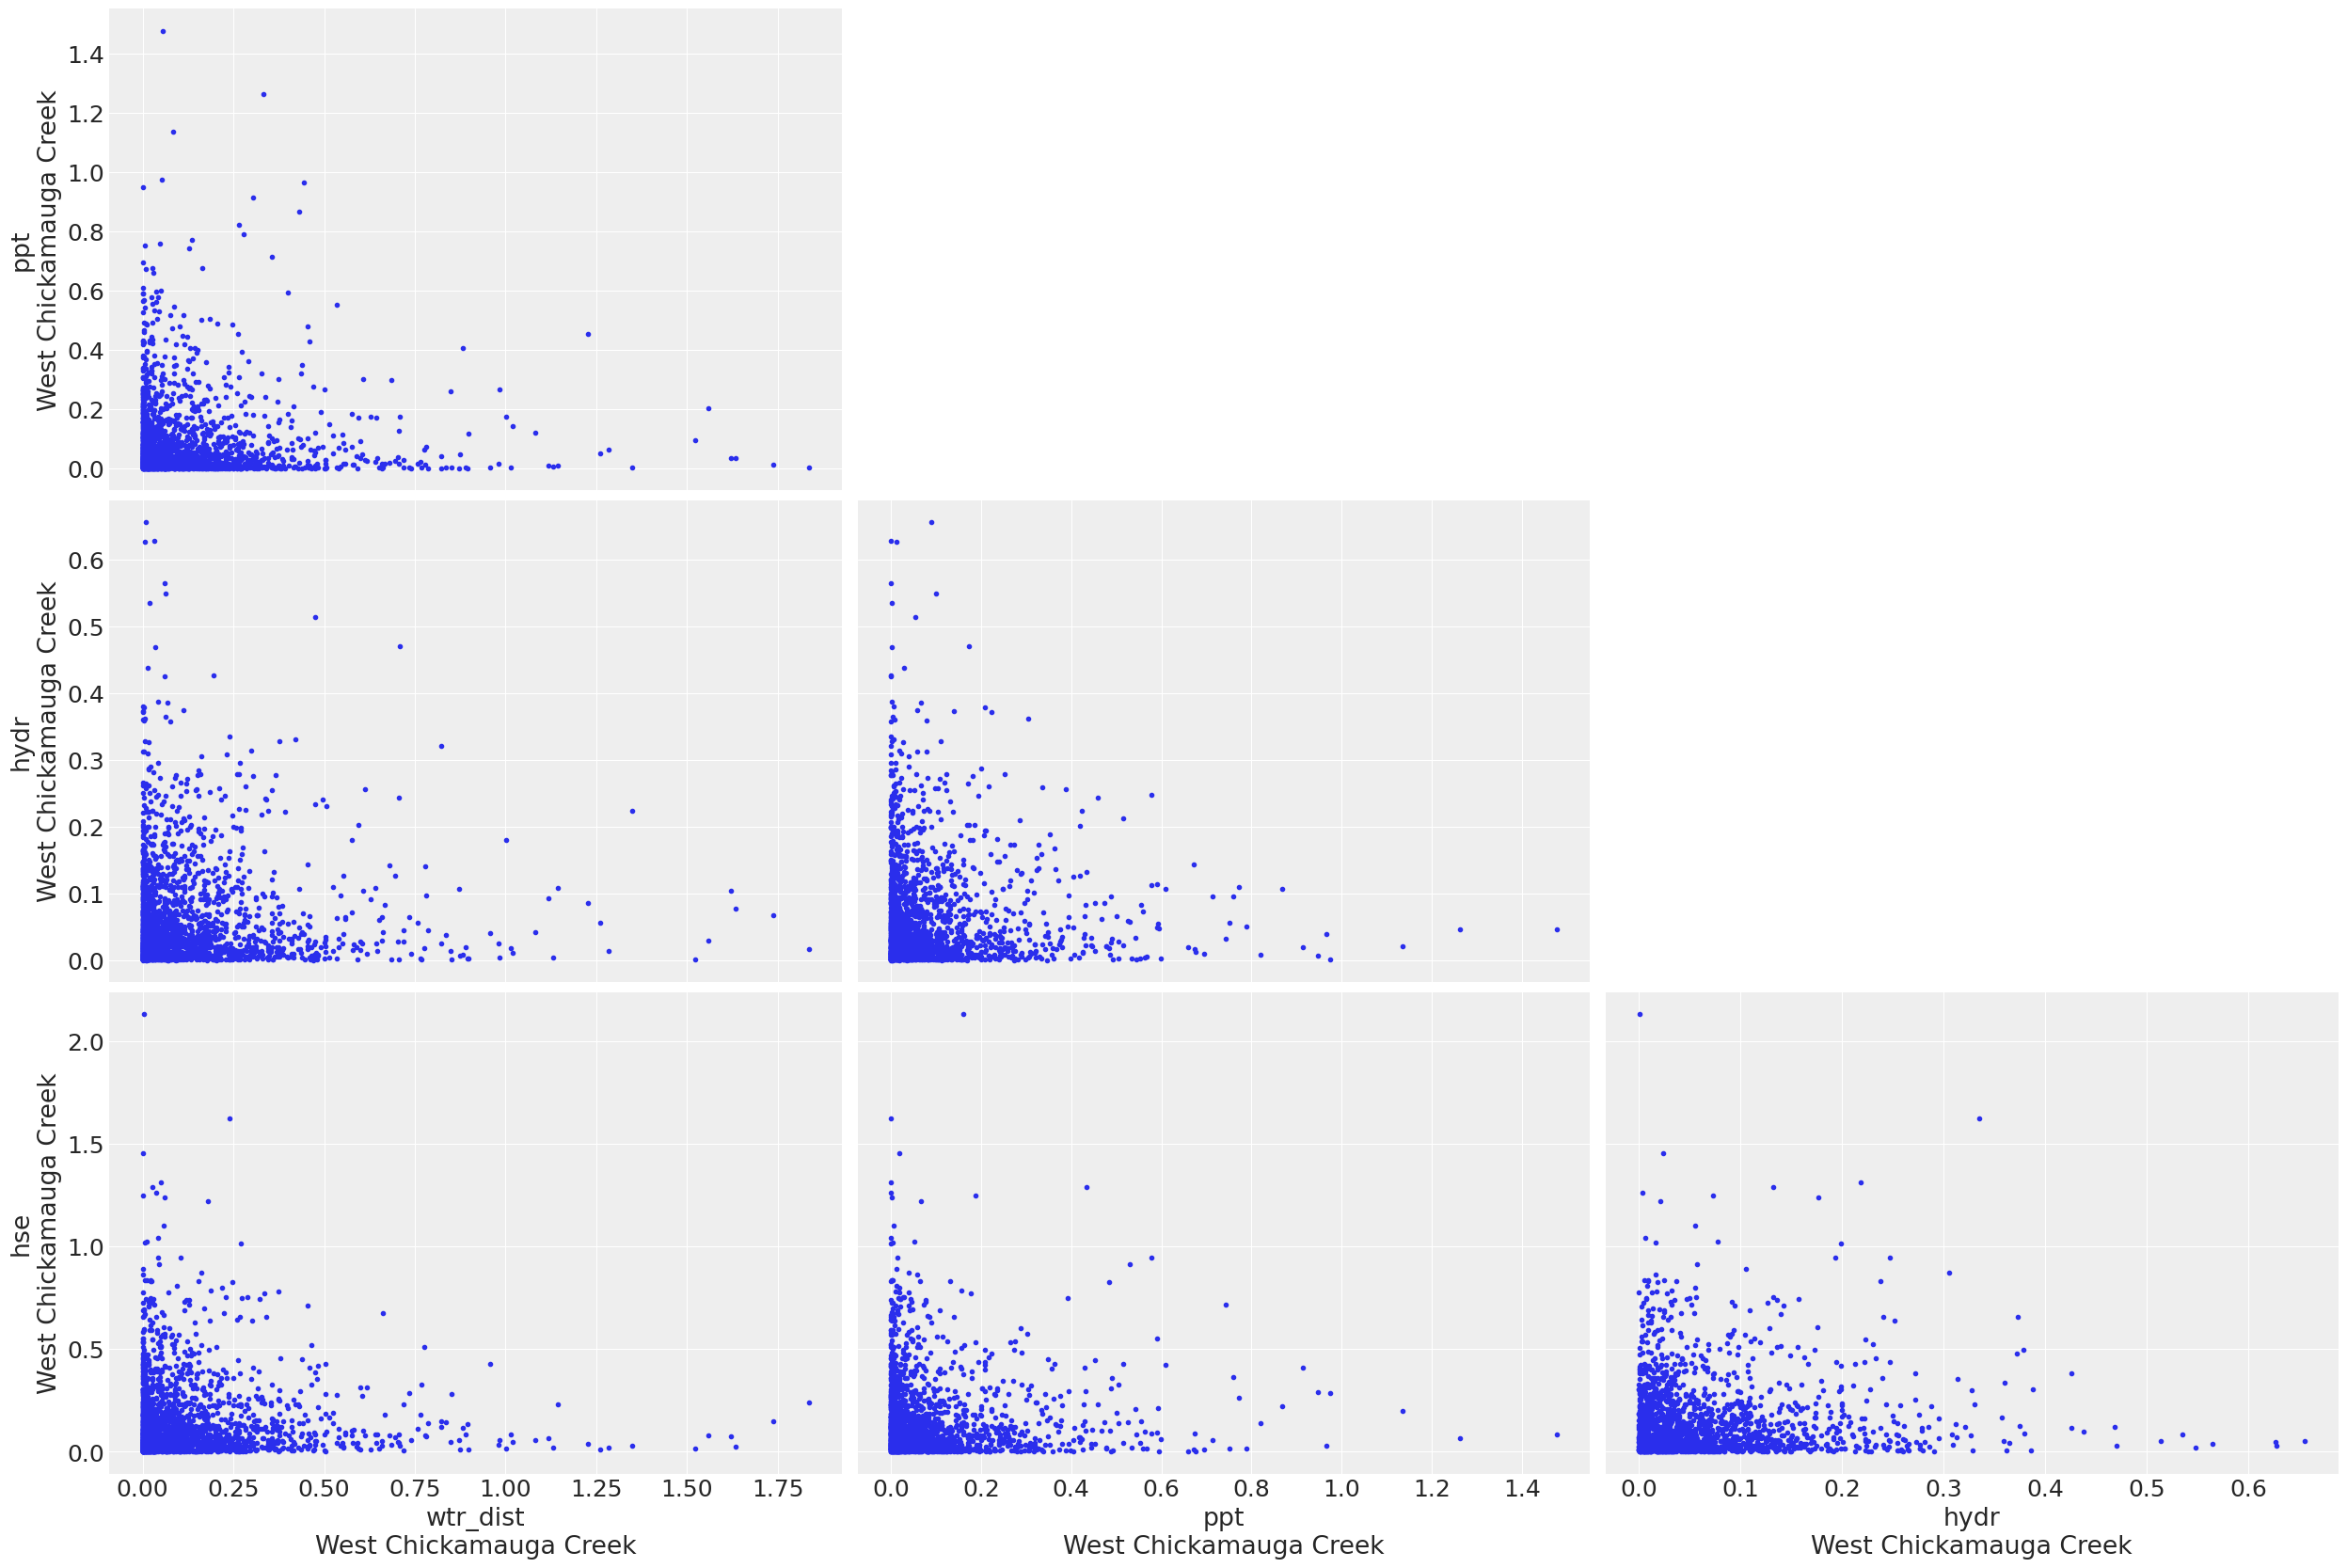

In [103]:
az.plot_pair(trace,
            var_names=var_names,
            coords=sample_coords,
            divergences=True,
            textsize=18)

In [123]:
print('correlation coefficient between:\n')
for var_a in var_names:
    for var_b in var_names:
        if var_a != var_b:
            var_a_ppc = trace.posterior[var_a][0,:,0].values
            var_b_ppc = trace.posterior[var_b][0,:,0].values
            m, c = np.polyfit(var_a_ppc,var_b_ppc,1)
            print(f"\t{var_a} and {var_b}: {m}")

correlation coefficient between:

	wtr_dist and ppt: -0.002751294066487995
	wtr_dist and hydr: -0.008792894565587296
	wtr_dist and hse: -0.004153763102452766
	ppt and wtr_dist: -0.009034071080842315
	ppt and hydr: -0.017630748401169096
	ppt and hse: -0.2881596026225998
	hydr and wtr_dist: -0.05573731656684551
	hydr and ppt: -0.03403599464140127
	hydr and hse: 0.10657581383452193
	hse and wtr_dist: -0.0061389563460021975
	hse and ppt: -0.12969983564526524
	hse and hydr: 0.02484833469468688
